# Вспомогательный код

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HistoryPlotter:
    def __init__(self):
        # dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epoсhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epoсhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epoсhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epoсhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epoсhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epoсhs"]))
                    ax[2].set_xticklabels(np.arange(history["epoсhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

# transforms for data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.13), (0.3))]
)

data_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
train_set, val_set = random_split(
    data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


In [ ]:
!pip install -q lightning tbparse
clear_output()

In [ ]:
import torch
from torch import nn
import lightning as L


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

        # Additionally, we will save training logs “manually”
        # for visualization within the lecture. Please limit yourself
        # to the native training logging tools from PytorchLightning
        # when training your own models.
        self.history = {"loss_on_train": [], "loss_on_test": [], "model_name": exp_name}

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_train", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_train"].append(loss.cpu().detach().item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())

# Слои нормализации

## Internal covariate shift


**Ковариантный сдвиг** — явление, когда признаки тренировочной и тестовой выборок **распределены по-разному**. Из-за этого мы можем получать плохие предсказания на тестовой выборке, когда модель просто не знает, что признаки могут находиться в другом распределении. [Подробнее 🎓[article]](https://www.researchgate.net/publication/339021786_Covariate_Shift_A_Review_and_Analysis_on_Classifiers)

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/covariate_shift.png" width="500"></center>





В [статье про Batch Normalization 🎓[arxiv]](https://arxiv.org/pdf/1502.03167.pdf) авторы предположили, что похожее явление имеет место внутри нейросети, назвав его **internal covariate shift**.

**Internal covariate shift** — это изменение распределения выхода слоя активации из-за изменения обучаемых параметров во время обучения.



<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/internal_covariate_shift_example.png" width="1000">

Пусть у нас $k$-ый нейрон $i$-го слоя переводит выход $i$−1 слоя с распределениями <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в новое пространство с распределением <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>.

При обучении:
- нейросеть делает предсказание,
- считается значение функции потерь,
- делается обратное распространение ошибки,
- обновляются веса.


После обновления весов $k$-ый нейрон $i$-го слоя будет переводить выходы $i$−1 слоя <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в пространство с другим распределением <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

При этом $i$+1 слой учился работать со старым распределением  <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>, и будет хуже обрабатывать <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

### Плохой вариант борьбы с этим

Давайте на каждом слое нормировать **каждый признак** (выход каждого нейрона), используя среднее и дисперсию по батчу:

$$ \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$




Проблема в том, что таким образом мы можем попасть в область линейной составляющей нашей функции. Например, в случае сигмоиды:

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/domain_of_linear_of_sigmoid_function.png" width="500"></center>

Получаем набор линейных слоев фактически без функций активации, следовательно, все вырождается в однослойную сеть. Не то, что нам надо.

## Batch Normalization

Нам надо дать нейронной сети **возможность перемещать распределение выходов** слоя из области $0$ и самой **подбирать дисперсию**. Для этой цели используется **батч-нормализация** (*batch normalization*), которая вводит в нейронную сеть дополнительную операцию между соседними скрытыми слоями. Она состоит из **нормализации** входящих (в слой батч-нормализации) значений, полученных от скрытого слоя, **масштабирования** и **сдвига** с применением двух новых параметров и передачи полученных значений на вход следующему скрытому слою.

 <center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization.png" width="400"> </center>

Параметры, используемые в батч-нормализации ($\gamma$ — отвечающий за **сжатие** и $\beta$ — отвечающий за **сдвиг**), являются **обучаемыми параметрами** (наподобие весов и смещений скрытых слоев).

Помимо обучаемых параметров $\gamma$ и $\beta$ в слое батч-нормализации существуют также необучаемые параметры: **скользящее среднее матожидания** (_Mean Moving Average_) и **скользящее среднее дисперсий** (_Variance Moving Average_), служащие для сохранения состояния слоя батч-нормализации.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnorm_layer_parameters.png" width="900">

Параметры $\gamma$, $\beta$, а также оба скользящих средних вычисляются для каждого слоя батч-нормализации отдельно и являются векторами с **длиной, равной количеству входящих признаков.**

В процессе обучения мы подаем в нейронную сеть **по одному мини-батчу за раз**. Процедуру обработки значений одного признака $x^{(k)}$ (фиолетовая колонка на изображении ниже), который для краткости мы будем обозначать $x$,  из одного мини-батча $ B = \{x_{1},\ldots, x_{m}\} $ можно представить следующим образом:



<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batch_normalization_compute_moving_average.png" width="1000">

Шаг **масштабирования** Gamma ($γ$) и шаг **сдвига** Beta ($β$) являются главным новшеством батч-нормализации, поскольку, в отличие от предыдущего рассмотренного примера, нормированные значения больше не обязаны иметь среднее, равное $0$, и единичную дисперсию. Батч-нормализация позволяет сдвигать среднее нормированных значений и масштабировать дисперсию. Фактически теперь **нейросеть даже может отменить нормализацию входных данных, если считает ее ненужной.**

Для наглядности проиллюстрируем размерности промежуточных переменных на следующем изображении:

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batch_normalization_compute_moving_average_scheme.png" width="1000">

После прямого прохода параметры $\gamma$ и $\beta$ **обновляются через обратное распространение ошибки** так же, как и веса скрытых слоев.

### Скользящее среднее

Выше мы обсуждали то, что в процессе обучения слой **батч-нормализации** рассчитывает значение **среднего и дисперсии** каждого признака в соответствующем **мини-батче**. Предположим, нам нужно сделать предсказание на **одном объекте**. Во время предсказания батч у нас уже отсутствует. Откуда брать среднее и дисперсию?

Во время предсказания используется **скользящее среднее**, которое было **рассчитано и сохранено в процессе обучения**.

$$\large \mu_{mov_{B}} = (1-\alpha)\mu_{mov_{B-1}}+\alpha\mu_{B} $$

$$\large \sigma_{mov_{B}} = (1-\alpha)\sigma_{mov_{B-1}}+\alpha\sigma_{B} $$

Обычно используется параметр $\alpha = 0.1$

Для перевода модели из режима обучения в режим тестирования и обратно в PyTorch используются `model.train()` и `model.eval()`.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{Батч-нормализация использует статистику по батчу}}&\large{\text{Батч-нормализация использует скользящие средние}}\\
\large{\text{Cкользящие средние копятся}}
\end{array}
$$



Почему используется именно **скользящее среднее**, а **не статистика всей обучающей выборки**?

При таком подходе нам бы пришлось хранить **средние всех признаков** для **всех батчей**, пропущенных через нейросеть в ходе обучения. Это невыгодно по памяти. Вместо этого **скользящее среднее** выступает в качестве приближенной оценки **среднего и дисперсии** обучающего набора. В этом случае эффективность использования ресурсов увеличивается: нам нужно **хранить в памяти только одно число** — значение скользящего среднего, полученное на последнем шаге.

Проиллюстрировать преимущество использования скользящего среднего можно на следующем примере:

Предположим, что у нас есть массив объектов, обладающих некоторым признаком $x$ (обучающая выборка), и некоторый черный ящик, извлекающий по $k$ объектов из этого массива (Dataloader). Наша задача — дать оценку ожидаемому среднему этих $k$ объектов. В данном примере для простоты будем извлекать $k$ объектов из некоего распределения случайным образом.

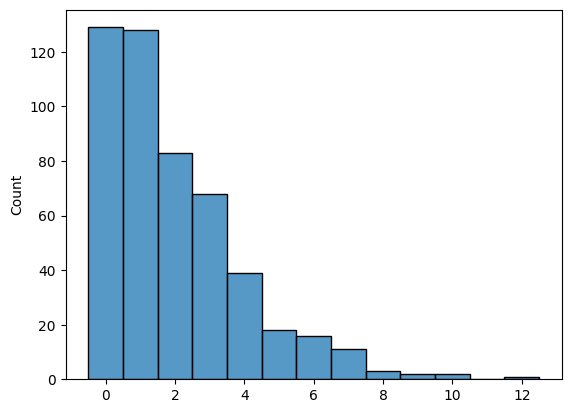

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

k = 500  # sample size
n = 2
p = 0.5

sample = np.random.negative_binomial(n, p, k)
sns.histplot(data=sample, discrete=True)
plt.show()

Оценить ожидаемое среднее теоретически, не зная, как распределен признак $x$ наших объектов, трудно. Мы можем собрать **большое количество средних** и произвести оценку с их помощью, но для этого нам потребуется хранить в памяти все эти значения, что приведет к неэффективному расходу ресурсов. Более эффективным решением будет воспользоваться **скользящим средним**. Давайте сравним эти два метода:

In [ ]:
ema = 0
alpha = 0.01
means = np.array([])

for i in range(10000):
    sample = np.random.negative_binomial(n, p, 50)
    ema = (1 - alpha) * ema + alpha * sample.mean()
    means = np.append(means, sample.mean())

Посчитаем количество памяти, затрачиваемое на хранение списка средних значений признака $x$ по выборкам из $k$ объектов, и **количество памяти**, затрачиваемое на хранение **скользящего среднего**:

In [ ]:
import sys

print(f"{sys.getsizeof(ema)} bytes")

32 bytes


Количество памяти для хранения **списка средних**:

In [ ]:
print(f"{sys.getsizeof(means)} bytes")

80112 bytes


Видно, что на хранение массива средних значений расходуется на порядки больше памяти, чем на хранение одного скользящего среднего. Теперь давайте воспользуемся тем, что мы сэмплировали случайные выборки из известного распределения, и можем теоретически рассчитать их среднее. В нашем примере мы извлекали выборки из негативного биномиального распределения с параметрами $n=2$ и $p=0.5$, для которого среднее рассчитывается по формуле: $$\text{mean}=\dfrac{np}{1-p}=2.$$

Мы знаем, что при достаточно большом количестве сэмплированных выборок среднее распределения выборочных средних будет стремиться к среднему генеральной совокупности. Сравним результаты, полученные с использованием сохраненных выборочных средних и скользящего среднего с теоретическим расчетом:

Среднее признака $x$ по $k$ объектам, оцененное с помощью **скользящего среднего**:

In [ ]:
print(f"{ema:.8f}")

1.98820216


Среднее признака $x$ по $k$ объектам, **оцененное по всем сэмплированным выборкам**:

In [ ]:
print(f"{means.mean():.8f}")

1.99826400


Видно, что мы получили довольно точную оценку, использовав скользящее среднее.

### Защита от нулей в знаменателе

Чтобы у нас не мог возникнуть $0$ в знаменателе, добавляем маленькое число — $\epsilon$. Например, $\epsilon = 10^{-5}$.


$$\large \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$

$$\large \text{BN}_{\gamma, \beta}(x_{i}) = \gamma \hat{x}_{i} + \beta $$

### Пример работы

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnorm_efficiency.png" width="550">

<em>Обучение нейронной сети с BN позвляет увеличить lr в 30 раз, сохранив стабильность обучения</em>

<em>Source: <a href="https://arxiv.org/pdf/1502.03167.pdf">Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift</a></em></center>



Этот метод действительно работает.
Видим, что нейросети с батч-нормализацией:

1. **Сходятся быстрее**, чем нейросети без неё.
2. Могут работать с **более высоким начальным значением learning rate**, причем это позволяет достигать лучших результатов.
3. Работают даже с функцией активации в виде **сигмоиды**. Без **BatchNorm** такая сеть не обучилась бы вовсе.

### Градиент

Вычисление **градиента BatchNorm** — интересное упражнение на понимание того, как работает **backpropagation**. В лекции мы это опускаем, можете ознакомиться самостоятельно:

[[blog] ✏️ Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)



### Batch Normalization как регуляризация

Почему для нейросети с батч-нормализацией можно использовать более высокие learning rate?

Оказывается, **батч-нормализация** делает **неявную регуляризацию на веса**.



Вспомним формулы:

$$ \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$

$$ \text{BN}_{\gamma, \beta}(x_{i}) = \gamma \hat{x}_{i} + \beta $$

Так как мы шкалируем, то домножение весов $W$ на константу $a$ не меняет выходные значения слоя:

$$BN((aW)u) = BN(Wu)$$

Градиент слоя по входу не меняется:

$$\dfrac {\partial BN((aW)u)} {\partial u} = \dfrac {\partial BN(Wu)} {\partial u}$$

А **градиент по весам уменьшается** в $a$ раз:

$$\dfrac {\partial BN((aW)u)} {\partial aW} = \dfrac 1 a \dfrac {\partial BN(Wu)} {\partial W} $$

Таким образом, нейросеть автоматически не дает большим весам расти.

### Сглаживающий эффект Batch Normalization

**Batch Normalization** была разработана на идее необходимости коррекции **Internal covariate shift**. В 2019 году вышла [статья 🎓[arxiv]](https://arxiv.org/pdf/1805.11604.pdf), которая показала, что влияние коррекции **Internal covariate shift** на качество обучения не так велико, как считали авторы **Batch Normalization**.

Другим интересным эффектом Batch Normalization оказалось **сглаживание ландшафта** функции потерь. Batch Normalization улучшает гладкость пространства решений и облегчает поиск в нем минимума. Именно благодаря сглаживанию ландшафта Batch Normalization справляется с затуханием и взрывом градиента.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnorm_helps_find_minimum_of_function.jpg" width="900"></center>

### Советы по использованию Batch Normalization

Стоит помнить, что с батч-нормализацией:

* Чем **меньше размер батча в обучении**, тем **хуже** будет работать BatchNormalization.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnorm_batch_size.png" width="500"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1803.08494.pdf">Group Normalization</a></em></center>





* В слое, после которого поставили Batch Normalization, можно **убрать bias** (параметр $\beta$ в BatchNormalization берет эту роль на себя).

* Другое расписание **learning rate: большее значение** в начале обучения и быстрое уменьшение в процессе обучения.

* Важно перемешивать объекты (составлять новые батчи) между эпохами. Единицей обучения параметров $\beta$ и $\gamma$ являются батчи. Если их не перемешивать, то из 6400 объектов в тренировочном датасете получим лишь 100 объектов (при условии, что в батче 64 объекта) для обучения $\beta$ и $\gamma$. Данное требование учитывается автоматически при использовании стохастического градиентного спуска в качестве алгоритма оптимизации параметров сети.

### Используем Batch Normalization в PyTorch

Так как наша модель из-за **Batch Normalization** ведет себя по-разному во время **обучения** и во время **тестирования**, мы должны прямо ей сообщать, обучается она сейчас или нет. Делается это при помощи функций `model.train` и `model.eval`

```python
# pseudocode for training a model in pure pytorch
def train(model, optimizer, criterion, train_loader, val_loader):
    for epoch in range(epochs):
        model.train()
        for train_batch in train_loader:
            do_train_step(model, train_batch, optimizer, criterion)
        
        model.eval()
        for val_batch in val_loader:
            do_test_step(model, val_batch, optimizer, criterion)
        
```

При использовании для обучения PyTorch Lightning **гарантируется**, что связанный с обучением `training_step()` будет выполнен для модели в состоянии `model.train()` и что связанный с запуском модели на тестовой выборке `validation_step()` будет выполнен для модели в состоянии `model.eval()`. **Это позволяет нам упростить код и не допустить ошибку**.

In [ ]:
class SimpleMNIST_NN_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

In [ ]:
model_name = "batchnorm2"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger
from warnings import simplefilter

simplefilter("ignore", category=RuntimeWarning)


trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


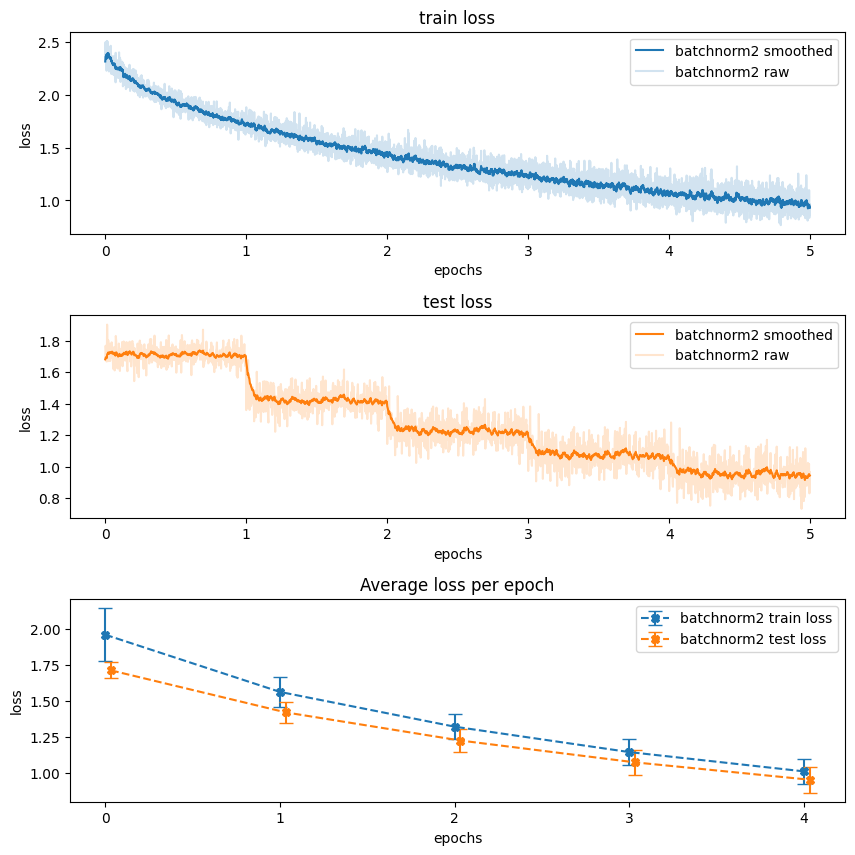

In [ ]:
history_plotter.add(history)
history_plotter.plot([model_name])

Попробуем, согласно советам, увеличить learning rate:

In [ ]:
model_name = "batchnorm_increased_lr"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name, optimizer_kwargs={"lr": 1e-2})

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


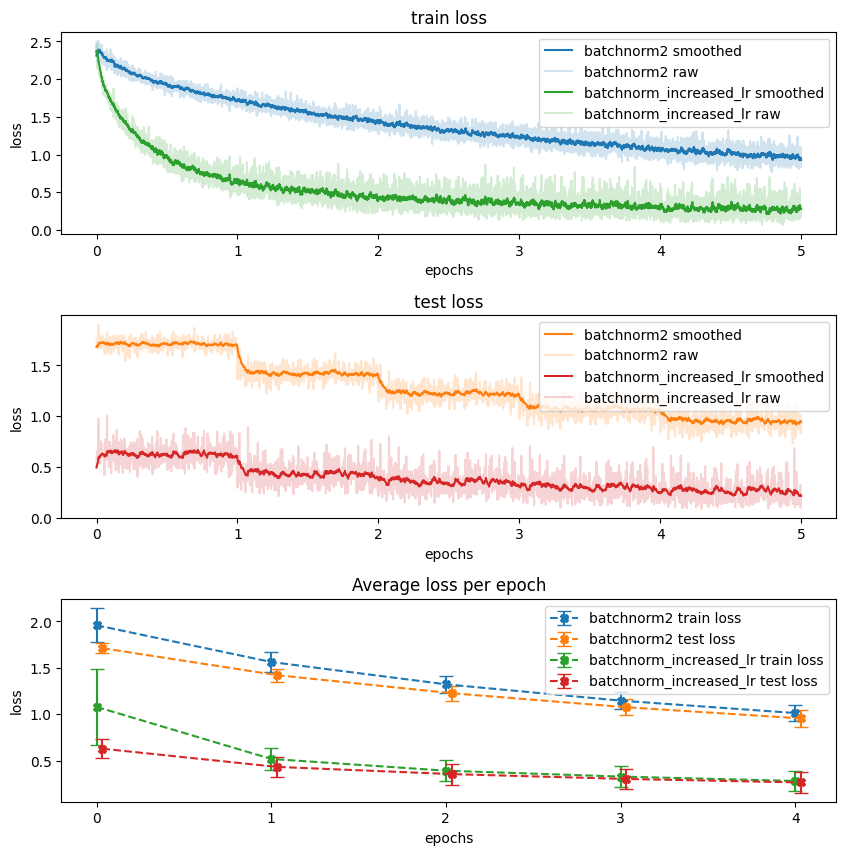

In [ ]:
history_plotter.plot(["batchnorm2", model_name])

### Ставить Batch Normalization до или после активации?



#### До

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization_before_activation.png" width="350"></center>

* **Рекомендуется авторами статьи, где предложили Batch Normalization**.
* Для **сигмоиды** BN, поставленная после активации, **не решает проблем** сигмоиды.
* Во многих сверточных архитектурах, например, [**ResNet** 🎓[arxiv]](https://arxiv.org/pdf/1512.03385.pdf) и [**MobileNetV2** 🎓[arxiv]](https://arxiv.org/pdf/1801.04381.pdf) (изучите на следующих лекциях), Batch Normalization ставится именно так.

#### После

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization_after_activation.png" width="350"></center>

* **Аргументация авторов статьи не до конца обоснована**.
* Обычно **сигмоиду не используют** в современных нейронных сетях.
* Для популярной **ReLU BN**, поставленная до активации, может приводить в определённых случаях к “умирающей **ReLU**”, когда большая часть ее входов меньше $0$, и поэтому через них градиент не проходит.

**BN — before or after ReLU?**

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/batchnormalization_before_or_after_relu.png" width="500">

<em>Source: <a href="https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md">BN experiments</a></em></center>

**Вывод:** В общем случае стоит располагать слой BN перед активацией, но с этим можно экспериментировать.